## License 

Copyright 2019 H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Straightforward Disparate Impact Analysis (DIA) with H2O Driverless AI (DAI)
***

Fairness is an incredibly important, but highly complex entity. So much so that leading scholars have yet to agree on a strict definition. However, there is a practical way to discuss and handle *observational* fairness, or how your model predictions affect different groups of people. This procedure is known as disparate impact analysis (DIA). DIA is far from perfect, as it relies heavily on user-defined thresholds and reference levels for disparity and does not attempt to remediate disparity or provide information on sources of disparity, but it is a fairly straightforward method to quantify your model’s behavior across sensitive demographic segments or other potentially interesting groups of observations. DIA is also an accepted, regulation-compliant tool for fair-lending purposes in the U.S. financial services industry. If it’s good enough for multibillion-dollar credit portfolios, it’s probably good enough for your project. 

This example notebook trains a DAI surrogate model to represent the now infamous COMPAS model and performs straightforward DIA on this surrogate model. The notebook starts by training a DAI classifier on the COMPAS data. A probability cutoff for making recidivism decisions is selected by maximizing the F1 statistic and confusion matrices are generated to summarize the DAI classifier's decisions across people of different races. A basic DIA procedure is then conducted using the information stored in the confusion matrices. 

To learn more about the topics of fairness and machine learning be sure to follow the book being written by Solon Barocas, Moritz Hardt and Arvind Narayanan: https://fairmlbook.org/. 

For Python fairness libraries that go far beyond the scope of this notebook see: 
* aequitas: https://github.com/dssg/aequitas
* AI Fairness 360: http://aif360.mybluemix.net/
* Themis: https://github.com/LASER-UMASS/Themis

#### Imports
Make sure to download and `pip install` the Python client from your DAI server for each new version of DAI.

In [1]:
# external file handing 
import os
import shutil
import subprocess

# basic data manipulation
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# DAI Python client (dowload from your DIA server for each new DAI version)
from h2oai_client import Client

#### Global constants

In [2]:
# overall random seed
SEED = 12345

# DAI constants
DAI_HOST = ''             # DAI host url 
DAI_USERNAME = ''         # Your DAI username
DAI_PASSWORD = ''         # Your DAI password
DAI_ACCURACY = 1          # ~ complexity of DAI validation schemes/ensembles; 1 fastest, 10 slowest
DAI_TIME = 1              # ~ number of features to attempt/time to run/early stopping criteria; 1 fastest, 10 slowest
DAI_INTERPRETABILITY = 1  # ~ complexity of attempted features/monotonicity contraints; 1 fastest, 10 slowest

# location of results files on disk
# for previously executed long-running jobs
PREDS_FILE_PATH = 'data' + os.sep + 'preds.csv'
VARIMP_FILE_PATH = 'data' + os.sep + 'varimp.csv'

# disparate impact analysis reference level and thresholds
REFERENCE_LEVEL = 'Caucasian'
PARITY_THRESHOLD_L = 0.8
PARITY_THRESHOLD_H = 1.25

# 1. Fetch and clean COMPAS data

#### Fetch data from Propublica GitHub

In [3]:
# fetch small data
! curl https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv -o data/compas-scores-two-years.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2486k  100 2486k    0     0  8100k      0 --:--:-- --:--:-- --:--:-- 8100k


#### Load data in notebook and remove personally identifiable information and duplicate columns

In [4]:
data = pd.read_csv('data/compas-scores-two-years.csv') # read feteched data
data.drop(['name', 'first', 'last'], axis=1, inplace=True) # remove personally identifiable information (PII) 
data.drop(['priors_count.1', 'decile_score.1'], axis=1, inplace=True) # remove some duplicate columns?
print(data.shape)

(7214, 48)


#### Basic cleaning, roughly following Propublica

In [5]:
# clean and prepare following Propublica
clean = data[data['days_b_screening_arrest'] <= 30]
clean = clean[clean['days_b_screening_arrest'] >= -30]
clean = clean[clean['is_recid'] != -1]
clean = clean[clean['c_charge_degree'] != 'O']
clean = clean[clean['score_text'] != 'N/A']

# create binary score for straightforward disparate impact analysis
clean['binary_target'] = np.where(clean['score_text'] == 'Low', 0, 1)
clean.shape

(6172, 49)

#### Remove IDs, dates, and unusable and high-cardinality columns 

In [6]:
# drop less useful modeling columns
drops = list(set(clean.columns) - set(['two_year_recid','binary_target', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree', 'priors_count', 'c_charge_desc', 'race', 'sex']))
print(drops)

['dob', 'v_decile_score', 'c_case_number', 'r_charge_desc', 'compas_screening_date', 'vr_case_number', 'r_case_number', 'decile_score', 'c_offense_date', 'is_recid', 'c_arrest_date', 'days_b_screening_arrest', 'c_jail_out', 'c_days_from_compas', 'vr_charge_desc', 'r_charge_degree', 'v_type_of_assessment', 'in_custody', 'event', 'r_jail_in', 'violent_recid', 'c_jail_in', 'vr_charge_degree', 'v_score_text', 'age_cat', 'v_screening_date', 'r_jail_out', 'is_violent_recid', 'out_custody', 'type_of_assessment', 'vr_offense_date', 'r_days_from_arrest', 'score_text', 'screening_date', 'r_offense_date', 'end', 'start', 'id']


#### Save cleaned data to client disk, to load to DAI server later

In [7]:
# create training data for DAI
clean.drop(drops, axis=1, inplace=True)
clean.to_csv('data/compas-scores-two-years-binary.csv')

#### Inspect clean data

In [8]:
clean.head(n=10)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,two_year_recid,binary_target
0,Male,69,Other,0,0,0,0,F,Aggravated Assault w/Firearm,0,0
1,Male,34,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,1,0
2,Male,24,African-American,0,0,1,4,F,Possession of Cocaine,1,0
5,Male,44,Other,0,0,0,0,M,Battery,0,0
6,Male,41,Caucasian,0,0,0,14,F,Possession Burglary Tools,1,1
7,Male,43,Other,0,0,0,3,F,arrest case no charge,0,0
8,Female,39,Caucasian,0,0,0,0,M,Battery,0,0
10,Male,27,Caucasian,0,0,0,0,F,"Poss 3,4 MDMA (Ecstasy)",0,0
11,Male,23,African-American,0,0,0,3,M,Battery,1,1
12,Female,37,Caucasian,0,0,0,0,M,Battery,0,0


# 2. Train DAI surrogate model 

In [9]:
# if previously saved results exist, use
# else train new model
if (not os.path.exists(PREDS_FILE_PATH)) or (not os.path.exists(VARIMP_FILE_PATH)):

    # connect to DAI 
    h2oai = Client(address=DAI_HOST, username=DAI_USERNAME, password=DAI_PASSWORD)

    # load training data from disk to DAI            
    cwd = os.getcwd()
    train_path_dai = (cwd + os.sep +  'data/compas-scores-two-years-binary.csv')
    train = h2oai.create_dataset_sync(train_path_dai)

    print('Training ...')
                   
    # start experiment training               
    experiment = h2oai.start_experiment_sync(
    
        # specify data 
        dataset_key=train.key, 
        validset_key='', # complex cross-validation occurs by default
        testset_key='', 
    
        # specify target & input info 
        target_col='binary_target',
        is_classification=True,
        is_timeseries=False,
        cols_to_drop=['two_year_recid'],
        weight_col=None,
        fold_col=None,
        orig_time_col='[OFF]',
        time_col='[OFF]',
    
        # specify system hyperparameters
        enable_gpus=False,
        seed=SEED,
        accuracy=DAI_ACCURACY,
        time=DAI_TIME,
        interpretability=DAI_INTERPRETABILITY,
        scorer='auc')

    print('Final Model Score on Validation Data: ' + str(round(experiment.valid_score, 3)))   
    
    # generate predictions
    # download to client, reformat
    prediction = h2oai.make_prediction_sync(experiment.key, train_path_dai, output_margin=False, pred_contribs=False)
    preds_path = h2oai.download(prediction.predictions_csv_path, '.')
    preds = pd.read_csv(preds_path)
    preds.drop('binary_target.0', axis=1, inplace=True)
    preds.rename(columns={'binary_target.1':'p_recid'}, inplace=True)   
    
    # save reformatted predictions 
    preds.to_csv(PREDS_FILE_PATH)
    
    # housekeeping
    os.remove(preds_path)
    
    # generate and load variable importance
    summary_path = h2oai.download(src_path=experiment.summary_path, dest_dir='.')
    dir_path = cwd + os.sep + 'h2oai_experiment_summary_' + experiment.key
    subprocess.call(['unzip', '-o', summary_path, '-d', dir_path], shell=False)
    features = pd.read_table(dir_path + os.sep + 'features.txt', sep=',', skipinitialspace=True)
    
    # save variable importance
    features.to_csv(VARIMP_FILE_PATH)
    
    # housekeeping
    shutil.rmtree(dir_path)
    os.remove(summary_path)
    
else:   
    
    # load predictions 
    print('Loading predictions from disk ...\n')
    preds = pd.read_csv(PREDS_FILE_PATH, index_col=0)
    print(preds.head())
    
    # load variable importance
    print('\nLoading feature importance from disk ...\n')
    features = pd.read_csv(VARIMP_FILE_PATH, index_col=0)
    features.sort_values(by='Relative Importance', inplace=True)
    

Training ...
Final Model Score on Validation Data: 0.825


#### Plot variable importance

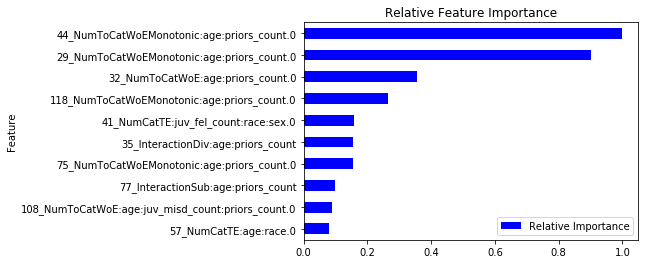

In [10]:
%matplotlib inline
features.sort_values(by='Relative Importance', inplace=True)
_ = features.loc[9:, :].plot(kind='barh', x='Feature', y='Relative Importance', color='b',
                             title='Relative Feature Importance')

We can see that race is not the most important variable in our surrogate model. Age and prior conviction count are the most important variables. We can also see that race interacts with other variables, including age. That race is not one of the most important variables is somewhat heartening from a fairness perspective. However, all of the input variables interact in complex ways, which is one reason why fairness is such an elusive concept in machine learning. 

# 3. Choose appropriate cutoff for model decisions

In [11]:
# merge predictions onto training data
clean.reset_index(drop=True, inplace=True)
clean_score = pd.concat([clean, preds], axis=1)
clean_score.head(n=10)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,two_year_recid,binary_target,p_recid
0,Male,69,Other,0,0,0,0,F,Aggravated Assault w/Firearm,0,0,0.024824
1,Male,34,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,1,0,0.309132
2,Male,24,African-American,0,0,1,4,F,Possession of Cocaine,1,0,0.877983
3,Male,44,Other,0,0,0,0,M,Battery,0,0,0.050523
4,Male,41,Caucasian,0,0,0,14,F,Possession Burglary Tools,1,1,0.745138
5,Male,43,Other,0,0,0,3,F,arrest case no charge,0,0,0.105543
6,Female,39,Caucasian,0,0,0,0,M,Battery,0,0,0.142034
7,Male,27,Caucasian,0,0,0,0,F,"Poss 3,4 MDMA (Ecstasy)",0,0,0.319122
8,Male,23,African-American,0,0,0,3,M,Battery,1,1,0.853029
9,Female,37,Caucasian,0,0,0,0,M,Battery,0,0,0.144768


#### Calculate PR-ROC from cross-validated model on out-of-time results

Predictive models often produce probabilities, not decisions. So to make a decision with a model-generated predicted probability for any one individual, you must specify a numeric cutoff above which we say a person will recidivate and below which we say they will not recidivate. Cutoffs play a crucial role in DIA as they impact the underlying measurements used to calculate diparity. In fact, tuning cutoffs carefully is a potential remediation tactic for any discovered disparity. There are many accepted ways to select a cutoff (besides simply using 0.5) and in this notebook the cutoff will be selected by striking a balance between the model's recall (true positive rate) and it's precision using the F1 statistic. For our procedure, the surrogate model predictions will be compared against whether a person did actually recidivate in the two years following the prediction. 

The DAI GUI will also show the best cutoffs by certain metrics. 

To learn more about confusion matrices see: https://en.wikipedia.org/wiki/Confusion_matrix.

In [12]:
def get_prroc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame

prroc_frame = get_prroc(clean_score, 'two_year_recid', 'p_recid')

#### Select cutoff based on F1
You can try other cutoffs as well.

In [13]:
best_cut = prroc_frame.loc[prroc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
best_cut

0.22

#### Plot AUC-PR Curve

An area under the curve for precision and recall (AUC-PR) plot is a typical way to visualize recall and precision for a predictive model. The F1 statistic is the harmonic mean of recall and precision, and we can visualize where F1 is maximized on with the AUC-PR curve.

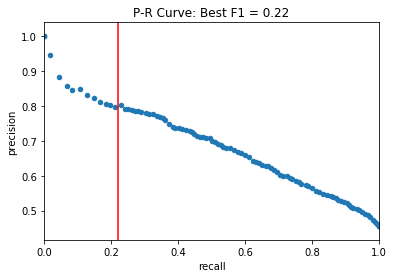

In [14]:
# Plot P-R ROC w/ best cutoff
title_ = 'P-R Curve: Best F1 = ' + str(best_cut)
ax = prroc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

# 4. Disparate impact analysis (DIA)

#### View overall confusion matrix

The basic DIA procedure in this notebook is based on measurements found commonly in confusion matrices, so confusion matrices are calculated as a precursor to DIA and to provide a basic summary of the DAI model's behavior in general and across eduction levels.

In [15]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from a pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[i, j] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + level)
    
    return cm_frame
    
get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', cutoff=best_cut)

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,2408,401
predicted: 0,2029,1334


#### View confusion matrices by race

In [16]:
races = list(clean_score['race'].unique())
races

['Other',
 'African-American',
 'Caucasian',
 'Hispanic',
 'Asian',
 'Native American']

In [17]:
other_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Other', cutoff=best_cut)
other_cm

Confusion matrix by race=Other


,actual: 1,actual: 0
predicted: 1,69,55
predicted: 0,58,161


In [18]:
afam_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='African-American', cutoff=best_cut)
afam_cm

Confusion matrix by race=African-American


,actual: 1,actual: 0
predicted: 1,1602,59
predicted: 0,1295,219


In [19]:
cauc_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Caucasian', cutoff=best_cut)
cauc_cm

Confusion matrix by race=Caucasian


,actual: 1,actual: 0
predicted: 1,609,213
predicted: 0,564,717


In [20]:
hisp_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Hispanic', cutoff=best_cut)
hisp_cm

Confusion matrix by race=Hispanic


,actual: 1,actual: 0
predicted: 1,116,73
predicted: 0,103,217


In [21]:
asian_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Asian', cutoff=best_cut)
asian_cm

Confusion matrix by race=Asian


,actual: 1,actual: 0
predicted: 1,7,1
predicted: 0,5,18


In [22]:
natam_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Native American', cutoff=best_cut)
natam_cm

Confusion matrix by race=Native American


,actual: 1,actual: 0
predicted: 1,5,0
predicted: 0,4,2


Eyeballing the raw confusion matrices, a few results are noteworthy. Some of the groups have very little training data, i.e. Asians and Native Americans. In general with such small amounts of training data, a predictive model will have high epistemic uncertainty for these small groups, meaning that no matter what probability the model generates for an individual in these groups, it should probably be treated as a low-confidence prediction. And what place do low confidence predictions have in determining if someone should serve jail time?

Also, the two largest groups, African-Americans and Caucasians, appear to have higher false negative rates. False negative rates for the reference class are worrisome from a fairness perspective because they essentially amount to giving members of a priviledged class more special treatment. In the recidivism case, false negatives are troubling from a saftey perspective as well, because they mean people who did commit additional crimes, potentially violent crimes, were given a low risk score.

Below we will see if these results amount to a disparate impact across racial groups w.r.t. to the user-defined reference group and thresholds.

#### Define several metrics for measuring disparity

To perform the following basic DIA many different values from the confusion matrices reflecting different prediction behavior are calculated. These metrics essentially help us understand the DAI surrogate model's overall performance and how it behaves when predicting:

* Recidivism correctly
* Non-recidivism correctly
* Recidivism incorrectly (type I errors)
* Non-recidivism incorrectly (type II errors)

In a real-life criminal risk scenario, type I errors essentially amount to false accusations of criminal behavior and type II errors result in allowing potentially dangerous individuals to go free with a low risk score. 

#### Dictionary of metrics used to assess parity

In [23]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
#'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much recidivism actually happens for this group
'Accuracy':   '(tp + tn) / (tp + tn +fp + fn)', # how often the model predicts recidivism correctly for this group

#### predicting recedivism will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* recidivate, how many the model predicted *correctly* would recidivate              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would recidivate, how many the model predicted *correctly* would recidivate

#### predicting recedivism won't happen
# (correctly)
'Specificity':              'tn / (fp + tn)', # out of the people in the group *that did not* recidivate, how many the model predicted *correctly* would not recidivate
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not recidivate, how many the model predicted *correctly* would not recidivate  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (fp + tn)', # out of the people in the group *that did not* recidivate, how many the model predicted *incorrectly* would recidivate
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would recidivate, how many the model predicted *incorrectly* would recidivate

#### analyzing errors - type II
# dangerous ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* recidivate, how many the model predicted *incorrectly* would not recidivate
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not recidivate, how many the model predicted *incorrectly* would not recidivate
}    

#### Utility function to translate metrics into Pandas statements

In [24]:
# small utility function
# translates abbreviated metric expressions into executable statements

def cm_exp_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression

#### Calculate all metrics across all races

In [25]:
# initialize dict of confusion matrices and corresponding rows of dataframe
cm_dict = {'Other': other_cm, 
           'African-American': afam_cm, 
           'Caucasian': cauc_cm, 
           'Hispanic': hisp_cm,
           'Asian': asian_cm,
           'Native American': natam_cm} 

metrics_frame = pd.DataFrame(index=races) # frame for metrics

# nested loop through:
# - races
# - metrics 
for level in races:
    for metric in metric_dict.keys():
              
        # parse metric expressions into executable pandas statements
        expression = cm_exp_parser(metric_dict[metric])

        # dynamically evaluate metrics to avoid code duplication
        metrics_frame.loc[level, metric] = eval(expression)  

# display results                
metrics_frame

,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
Other,0.670554,0.543307,0.556452,0.745370,0.735160,0.254630,0.443548,0.456693,0.264840
African-American,0.573543,0.552986,0.964479,0.787770,0.144650,0.212230,0.035521,0.447014,0.855350
Caucasian,0.630528,0.519182,0.740876,0.770968,0.559719,0.229032,0.259124,0.480818,0.440281
Hispanic,0.654224,0.529680,0.613757,0.748276,0.678125,0.251724,0.386243,0.470320,0.321875
Asian,0.806452,0.583333,0.875000,0.947368,0.782609,0.052632,0.125000,0.416667,0.217391
Native American,0.636364,0.555556,1.000000,1.000000,0.333333,0.000000,0.000000,0.444444,0.666667


Looking at the metrics across races we see that the surrogate model's accuracy rates are generally low, that false positive rates are lower than false negative rates, and specificity - or true negative rate - is generally high. A few values, such as the higher accuracy rate for Asians, pop out of the table. We will test below whether this value is evidence of disparate impact.

#### Calculate disparate impact against reference level, i.e. Caucasian, for all races and metrics

In [27]:
# init frame to store disparity measures
disp_frame = pd.DataFrame(index=races)

# compare all metrics to reference level
disp_frame = metrics_frame/metrics_frame.loc[REFERENCE_LEVEL, :]

# change column names
disp_frame.columns=[col + ' Disparity' for col in metrics_frame.columns]

# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (PARITY_THRESHOLD_L < val < PARITY_THRESHOLD_H) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)

,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
Other,1.06348,1.04647,0.751073,0.966798,1.31344,1.11176,1.71172,0.949824,0.601525
African-American,0.909624,1.06511,1.30181,1.02179,0.258433,0.926639,0.13708,0.929694,1.94274
Caucasian,1,1,1,1,1,1,1,1,1
Hispanic,1.03758,1.02022,0.82842,0.970567,1.21155,1.09908,1.49057,0.978165,0.731067
Asian,1.27901,1.12356,1.18103,1.2288,1.39822,0.2298,0.482394,0.866578,0.493756
Native American,1.00926,1.07006,1.34975,1.29707,0.595537,0,0,0.92435,1.51418


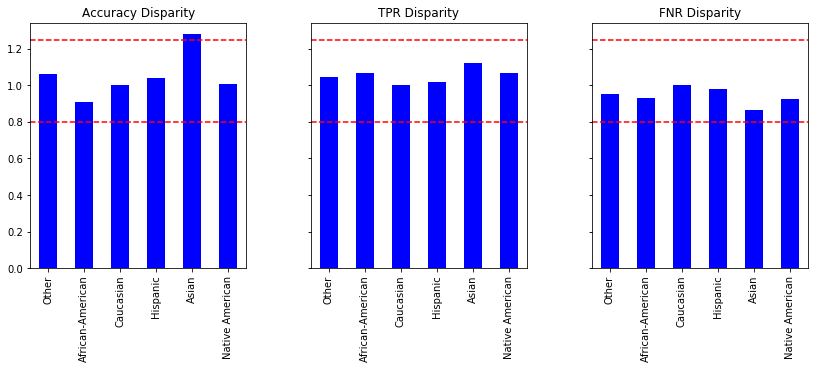

In [28]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0.0, right=1.8, wspace=0.3)

_ = disp_frame['Accuracy Disparity'].plot(kind='bar', color='b', title='Accuracy Disparity', ax=ax0)
_ = ax0.axhline(PARITY_THRESHOLD_H, color='r', linestyle='--')
_ = ax0.axhline(PARITY_THRESHOLD_L, color='r', linestyle='--')

_ = disp_frame['True Positive Rate Disparity'].plot(kind='bar', color='b', title='TPR Disparity', ax=ax1)
_ = ax1.axhline(PARITY_THRESHOLD_H, color='r', linestyle='--')
_ = ax1.axhline(PARITY_THRESHOLD_L, color='r', linestyle='--')

_ = disp_frame['False Negative Rate Disparity'].plot(kind='bar', color='b', title='FNR Disparity', ax=ax2)
_ = ax2.axhline(PARITY_THRESHOLD_H, color='r', linestyle='--')
_ = ax2.axhline(PARITY_THRESHOLD_L, color='r', linestyle='--')

After comparing metrics to the reference level and applying the thresholds, we can see there is disparate impact for most of the metrics for at least one race, but the surrogate model is displaying parity across races for true positive rate and false negative rate.

#### Check parity for each metric and for a few overall measures

In [29]:
# parity checks
# low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 ===> parity, else disparity 

# init frame for parity
par_frame = pd.DataFrame(index=races, 
                         columns=[col + ' Parity' for col in metrics_frame.columns])
# nested loop through: 
# - races
# - disparity metrics
for i, _ in enumerate(races):
    for j, _ in enumerate(par_frame.columns):
        par_frame.iat[i, j] = (PARITY_THRESHOLD_L < disp_frame.iat[i, j] < PARITY_THRESHOLD_H)

# add overall parity checks
# Type I Parity: Fairness in both FDR Parity and FPR Parity
# Type II Parity: Fairness in both FOR Parity and FNR Parity
# Equalized Odds: Fairness in both FPR Parity and TPR Parity
# Supervised Fairness: Fairness in both Type I and Type II Parity
# Overall Fairness: Fairness across all parities for all attributes
par_frame['Type I Parity'] = (par_frame['False Discovery Rate Parity']) & (par_frame['False Positive Rate Parity'])
par_frame['Type II Parity'] = (par_frame['False Omissions Rate Parity']) & (par_frame['False Negative Rate Parity'])
par_frame['Equalized Odds'] = (par_frame['False Positive Rate Parity']) & (par_frame['True Positive Rate Parity'])
par_frame['Supervised Fairness'] = (par_frame['Type I Parity']) & (par_frame['Type II Parity'])
par_frame['Overall Fairness'] = par_frame.all(axis='columns')
par_frame.loc['All Races', :] = par_frame.all(axis='index')
    
# small utility function to format pandas table output    
def color_false_red(val):

    color = 'red' if not val else 'blue'
    return 'color: %s' % color 
    
par_frame.style.applymap(color_false_red)
       

,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
Other,True,True,False,True,False,True,False,True,False,False,False,True,False,False
African-American,True,True,False,True,False,True,False,True,False,False,False,True,False,False
Caucasian,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Hispanic,True,True,True,True,True,True,False,True,False,False,False,True,False,False
Asian,False,True,True,True,False,False,False,True,False,False,False,False,False,False
Native American,True,True,False,False,False,False,False,True,False,False,False,False,False,False
All Races,False,True,False,False,False,False,False,True,False,False,False,False,False,False


The surrogate model does meet the criteria of true positive rate parity and false negative rate parity but fails to meet any of the higher, combined parity criteria and certainly falls short of overall fairness. To reduce disparate impact, users could further tune the probability cutoff, try different DAI hyperparameter settings, and could try newer techniques that reweigh data prior to training to reduce disparate impact.

The model trained in this notebook is simply meant to represent the proprietary COMPAS risk assessment instrument (RIA). As this is a simple, educational example, no gaurantees are made as to the fidelity of that representation. It is clear that a model such as the model trained here is likely inappropriate for fairness-sensitive, life-critical decision support -- such as suggesting the likelihood of future criminal action. These results also bring into focus areas of application where machine learning and predictive modeling may simply be inappropriate. 

***

#### Conclusion

This notebook outlines a basic approach to DIA. In a complex, real-world machine learning project the hard-to-define phenomenas of sociological bias and unfairness can materialize in many ways and from many different sources. Although far from a flawless technique, the beauty of DIA is it is straightforward to implement, functions in a model-agnostic fashion on known labels and model predictions, and is applied in complex real-world fair lending situations, so it can probably be applied to your model too!

Why risk being called out in the media for training an unfair model? Or why not investigate the monetary opportunity costs of type I errors and potential losses from type II errors? Why not do the right thing and investigate how your model treats people?
